In [16]:
# Traverses that are going to be extracted
# extract_traverses = ["sunset1", "sunset2"]
extract_traverses = ["sunset1", "sunset2", "morning", "sunrise", "daytime"]

# Read coordinates for selected traverses


In [17]:
from utils.gps_utils import get_gps
from constant_paths import event_paths, frame_paths, nmea_paths, video_beginning,video_paths
coordinates = {}

for traverse in extract_traverses:
    coordinates[traverse] = get_gps(nmea_paths[traverse])

In [18]:
import pandas as pd
import numpy as np

# Tolerance hyperparameters
space_tolerance = 1e-4
time_tolerance = 100



s1_gps = pd.DataFrame(coordinates[extract_traverses[0]])
s2_gps = pd.DataFrame(coordinates[extract_traverses[1]])

# Rename columns
s1_gps.columns = ["lat", "long", "time"]
s2_gps.columns = ["lat", "long", "time"]

# Add positional index
s1_gps = s1_gps.reset_index().rename(columns={'index': 'index_s1'})
s2_gps = s2_gps.reset_index().rename(columns={'index': 'index_s2'})

# Fusion of the two dataframe
merged_df = s1_gps.merge(s2_gps, how='cross')

# Filter the cross product within a certain tolerance (gps imprecision) and timing 
filtered_df = merged_df[
    (abs(merged_df['lat_x'] - merged_df['lat_y']) <= space_tolerance) &
    (abs(merged_df['long_x'] - merged_df['long_y']) <= space_tolerance) &
    (abs(merged_df['time_x'] - merged_df['time_y']) <= time_tolerance)
]

# Keep only positional indices
final_df = filtered_df[['index_s1', 'index_s2']].reset_index(drop=True)

# Remove duplicates (when the car is not moving) to match indices
final_df = final_df.drop_duplicates(subset=['index_s1'], keep='first')
final_df = final_df.drop_duplicates(subset=['index_s2'], keep='first')
final_df = final_df[['index_s1', 'index_s2']].reset_index(drop=True) # Reset dataframe indices

print(f"{len(final_df)} point(s) match spatio-temporal tolerances")

# Convert sampled points in numpy array for ease of use
sampled_points = {
    extract_traverses[0]: final_df['index_s1'].to_numpy(),
    extract_traverses[1]: final_df['index_s2'].to_numpy()
}

final_df.head()

547 point(s) match spatio-temporal tolerances


,index_s1,index_s2
0,3,0
1,4,1
2,5,2
3,6,3
4,7,4


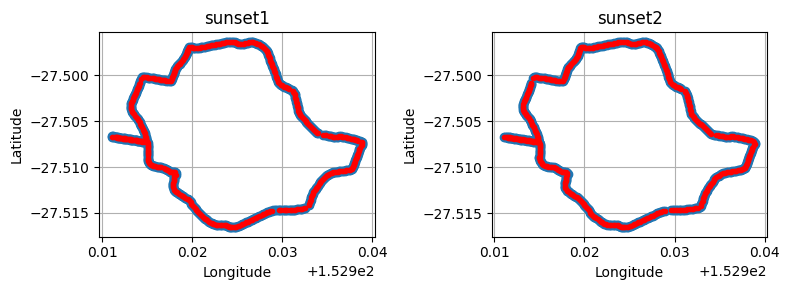

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
for index, traverse in enumerate(sampled_points):
    longitudes = coordinates[traverse].T[1]
    latitudes = coordinates[traverse].T[0]
    
    plt.subplot(1, 2,index+1)
    plt.plot(longitudes, latitudes, marker='o', linestyle='-')
    for point in sampled_points[traverse]:
        plt.plot(longitudes[point], latitudes[point], marker='.', color='r')
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.title(f"{traverse}")
plt.tight_layout()

# Matching timestamps between frames and GPS 

In [5]:
import os
from os.path import join, basename
from os import listdir

def get_timestamp_matches(timestamps, timestamps_to_match):
    timestamps_matched = np.array([np.abs(timestamps - ts).argmin() for ts in timestamps_to_match])
    return timestamps_matched

timestamp_gps = {}
timestamp_frame = {}
timestamp_file_path = {}
matched_timestamp = {}

for traverse in extract_traverses:
    timestamp_gps[traverse] = [t + video_beginning[traverse] for t in coordinates[traverse][:,2]]
    timestamp_frame[traverse] = sorted([float(os.path.splitext(basename(f))[0]) for f in listdir(frame_paths[traverse]) if f.endswith('.png')])
    timestamp_file_path[traverse] = sorted([join(frame_paths[traverse], f) for f in listdir(frame_paths[traverse]) if f.endswith('.png')])
    matched_timestamp[traverse] = get_timestamp_matches(timestamp_frame[traverse], timestamp_gps[traverse])

1587453086.351282
1587540702.6332345


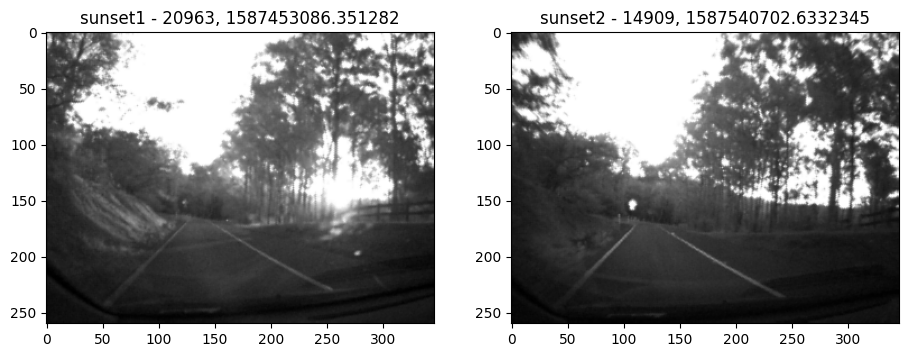

In [6]:
import pandas as pd
from PIL import Image

def getCorrelationValue(reference: np.array, comparison: np.array) -> float:
    reference = pd.DataFrame(reference.flatten())
    comparison = pd.DataFrame(comparison.flatten())
    result = reference.corrwith(comparison)
    return result[0]

def getTimestampFromFilePath(filepath):
    # Assuming the file path is from the timestampFilePath dictionnary
    return float(filepath.strip('.png\n').split("/")[-1])

# Get the calibrated timestamp for event data, (file name of the frame)
calibrated_timestamps = {}
for traverse in extract_traverses:
    calibrated_timestamps[traverse] = [(getTimestampFromFilePath(timestamp_file_path[traverse][image_index])) for image_index in matched_timestamp[traverse]]


frame_index = 400 
plt.figure(figsize=(11,8))
for index, traverse in enumerate(extract_traverses):
    plt.subplot(1, 2, index+1)
    image_index = matched_timestamp[traverse][sampled_points[traverse][frame_index]] 
    frame = np.array(Image.open(timestamp_file_path[traverse][image_index]).convert('L'))

    print(calibrated_timestamps[traverse][frame_index])
    plt.title(f"{traverse} - {image_index}, {calibrated_timestamps[traverse][frame_index]}")
    plt.imshow(frame, cmap="gray")

Will use fixed size event windows with 100000 events
Output frame rate: variable
8471
86


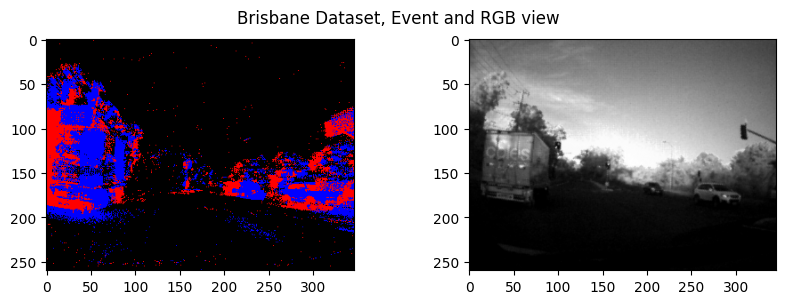

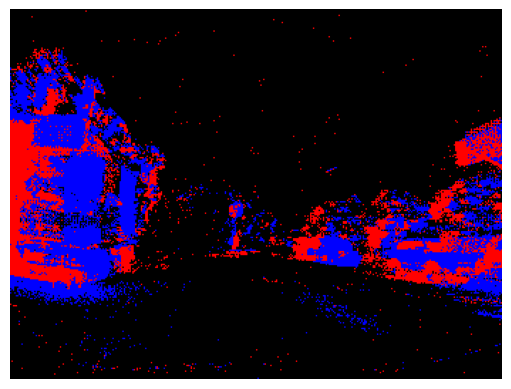

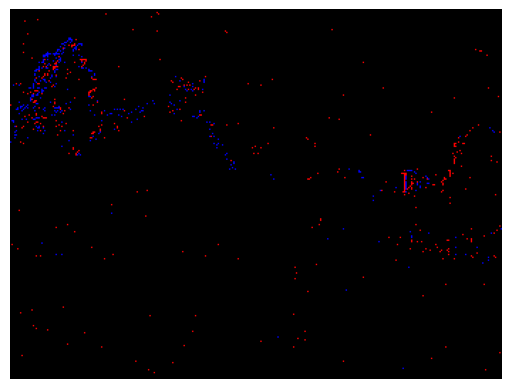

In [34]:
def convertListOfEventsIn2DVector(patternList, dimension=[260,346,2]):
    outVector = np.zeros((dimension[0], dimension[1], 3)) # 2 Channels, ON & OFF 
    for event in patternList:
        # Timestamp, X, Y, Polarity
        x = int(event[2])
        y = int(event[1])
        polarity = int(event[3])
        outVector[x][y][polarity] += 1
    return outVector

def addChannel(events):
    result = np.zeros((events.shape[0], events.shape[1], 3))
    result[:,:,0] = events[:,:,1] # Index 1 = ON on channel RED
    result[:,:,2] = events[:,:,0] # Index 0 = OFF on channel BLUE
    return result

def getVisualReprTimeWindow(events):   
    # Events should be dual channel array [W,H,2]
    maxChannel = np.argmax(events, axis=-1)
    maxValues = np.max(events, axis=-1)
    result = np.zeros_like(events)
    for x in range(events.shape[0]):
        for y in range(events.shape[1]):
            if maxValues[x][y] != 0:
                result[x][y][maxChannel[x][y]] = 1
    return addChannel(result)

def getTimestampFromFilePath(filepath):
    # Assuming the file path is from the timestampFilePath dictionnary
    return float(filepath.strip('.png\n').split("/")[-1])

calibrated_timestamps = {}
calibrated_file_paths = {}
# for traverse in extract_traverses:
#     #calibrated_file_paths[traverse] = [(timestamp_file_path[traverse][image_index]) for image_index in timestamp_file_path[traverse]]
#     calibrated_timestamps[traverse] = [(getTimestampFromFilePath(timestamp_file_path[traverse][image_index])) for image_index in matched_timestamp[traverse]]

# DUMB SHIT
for traverse in sampled_points:
    calibrated_timestamps[traverse] = []
for i in range((len(sampled_points[extract_traverses[0]]))):
    for index, traverse in enumerate(sampled_points):
        image_index = matched_timestamp[traverse][sampled_points[traverse][i]]
        calibrated_timestamps[traverse].append(getTimestampFromFilePath(timestamp_file_path[traverse][image_index]))

#########""""
from utils.event_readers import FixedSizeEventReader


frame_index = 20

traverse = "sunset1"
event_reader = FixedSizeEventReader(event_paths[traverse], num_events=100000)
image_index = matched_timestamp[traverse][sampled_points[traverse][frame_index]]

print(image_index)
print(len(calibrated_timestamps[traverse]))


event_pattern = next(event_reader)
while event_pattern[0][0] <  calibrated_timestamps[traverse][frame_index]:
    try:
        event_pattern = next(event_reader)
    except StopIteration:
        break

frame = np.array(Image.open(timestamp_file_path[traverse][image_index]).convert('L'))

plt.figure(figsize=(10,3))
plt.suptitle("Brisbane Dataset, Event and RGB view")
plt.subplot(1,2,1)
plt.imshow(getVisualReprTimeWindow(convertListOfEventsIn2DVector(event_pattern)))
plt.subplot(1,2,2)
plt.imshow(frame, cmap="gray")

plt.figure()
plt.imshow(getVisualReprTimeWindow(convertListOfEventsIn2DVector(event_pattern)))
plt.axis('off')
plt.savefig("event_pattern.png")


traverse = "sunrise"
event_pattern = next(event_reader)
while event_pattern[0][0] <  calibrated_timestamps[traverse][frame_index]:
    try:
        event_pattern = next(event_reader)
    except StopIteration:
        break

plt.figure()
plt.imshow(getVisualReprTimeWindow(convertListOfEventsIn2DVector(event_pattern)))
plt.axis('off')
plt.savefig("event_pattern_2.png")


np.save(f"calibrated_timestamps_events{extract_traverses[0]}_{extract_traverses[1]}.npy", calibrated_timestamps)
np.save(f"timestamp_file_path_frames{extract_traverses[0]}_{extract_traverses[1]}.npy", timestamp_file_path)
np.save(f"matched_timestamp{extract_traverses[0]}_{extract_traverses[1]}.npy", matched_timestamp)

Will use fixed size event windows with 100000 events
Output frame rate: variable


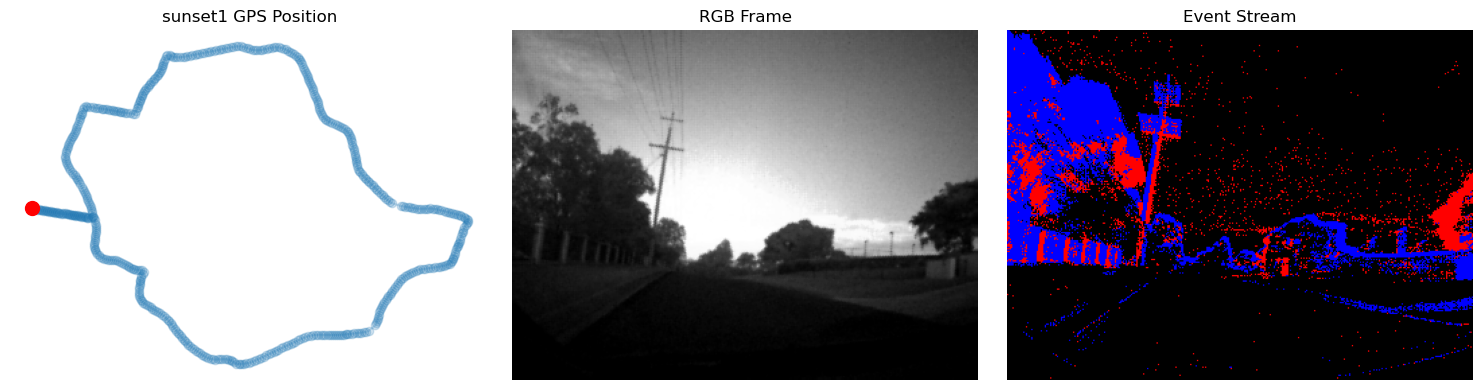

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from utils.event_readers import FixedSizeEventReader


# Create figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

# Add a higher frame rate by interpolating between actual data points
interpolation_factor = 4  # Number of frames to interpolate between each data point
actual_frames = len(coordinates[traverse].T[1])
total_frames = (actual_frames - 1) * interpolation_factor + 1

# Create interpolated coordinates
from scipy.interpolate import interp1d

original_indices = np.arange(actual_frames)
interpolated_indices = np.linspace(0, actual_frames-1, total_frames)

# Create interpolation functions for longitude and latitude
longitude_interpolator = interp1d(original_indices, longitudes, kind='cubic')
latitude_interpolator = interp1d(original_indices, latitudes, kind='cubic')

# Compute interpolated coordinates
interpolated_longitudes = longitude_interpolator(interpolated_indices)
interpolated_latitudes = latitude_interpolator(interpolated_indices)

# Get the traverse data
traverse = "sunset1"
longitudes = coordinates[traverse].T[1].tolist()
latitudes = coordinates[traverse].T[0].tolist()

# Initialize event reader
event_reader = FixedSizeEventReader(event_paths[traverse], num_events=100000)

# Plot the trajectory (make it very light)
ax1.plot(longitudes, latitudes, marker='o', linestyle='-', alpha=0.2)
point_artist, = ax1.plot([longitudes[0]], [latitudes[0]], marker='o', color='red', markersize=10)

# Initialize trail points with empty data
trail_x, trail_y = [], []
trail_points, = ax1.plot(trail_x, trail_y, 'o', color='blue', alpha=0.5, markersize=6)

# Initialize sampled points with empty data (new)
sampled_points_artist, = ax1.plot([], [], 'o', color='green', alpha=0.8, markersize=8)

ax1.axis('off') 
ax1.grid(True)
ax1.set_title(f"{traverse} GPS Position")

# Initialize image displays
first_image_index = matched_timestamp[traverse][sampled_points[traverse][0]]
first_frame = np.array(Image.open(timestamp_file_path[traverse][first_image_index]).convert('L'))
img_display = ax2.imshow(first_frame, cmap='gray')
ax2.set_title("RGB Frame")
ax2.axis('off')

# Initialize event display with empty frame
event_display = ax3.imshow(np.zeros((260, 346, 3)))  # Adjust dimensions if needed
ax3.set_title("Event Stream")
ax3.axis('off')

def update(frame):
    # Convert interpolated frame to actual data index
    actual_idx = int(frame / interpolation_factor)
    
    # Update trajectory point with interpolated position
    point_artist.set_data([interpolated_longitudes[frame]], [interpolated_latitudes[frame]])
    
    # Update trail points using interpolated coordinates with larger intervals
    n_frames_between_points = 40 * interpolation_factor  # Increased interval between trail points
    trail_length = 10  # Reduced number of trail points for cleaner visualization
    
    start_idx = max(0, frame - (trail_length * n_frames_between_points))
    trail_indices = range(int(start_idx), frame, n_frames_between_points)
    
    trail_x = [interpolated_longitudes[i] for i in trail_indices]
    trail_y = [interpolated_latitudes[i] for i in trail_indices]
    trail_points.set_data(trail_x, trail_y)
    
    # Update sampled points
    valid_samples = sampled_points[traverse][sampled_points[traverse] <= actual_idx]
    if len(valid_samples) > 0:
        sampled_x = [longitudes[i] for i in range(len(valid_samples), 10)]
        sampled_y = [latitudes[i] for i in range(len(valid_samples), 10)]
        sampled_points_artist.set_data(sampled_x, sampled_y)
    
    # Get the two closest frames for interpolation
    closest_sample_idx = np.abs(sampled_points[traverse] - actual_idx).argmin()
    next_sample_idx = min(closest_sample_idx + 1, len(sampled_points[traverse]) - 1)
    
    # Load both frames
    current_image_index = matched_timestamp[traverse][sampled_points[traverse][closest_sample_idx]]
    next_image_index = matched_timestamp[traverse][sampled_points[traverse][next_sample_idx]]
    
    current_frame = np.array(Image.open(timestamp_file_path[traverse][current_image_index]).convert('L'), dtype=float)
    next_frame = np.array(Image.open(timestamp_file_path[traverse][next_image_index]).convert('L'), dtype=float)
    
    # Calculate interpolation weight
    weight = (frame % interpolation_factor) / interpolation_factor
    
    # Interpolate between frames
    interpolated_frame = (1 - weight) * current_frame + weight * next_frame
    img_display.set_array(interpolated_frame)
    
    # Handle events (keep original logic as events are already continuous)
    target_timestamp = calibrated_timestamps[traverse][closest_sample_idx]
    event_pattern = next(event_reader)
    while event_pattern[0][0] < target_timestamp:
        try:
            event_pattern = next(event_reader)
        except StopIteration:
            event_reader.reset()
            event_pattern = next(event_reader)
            
    event_img = getVisualReprTimeWindow(convertListOfEventsIn2DVector(event_pattern))
    event_display.set_array(event_img)
    
    return [point_artist, trail_points, sampled_points_artist, img_display, event_display]

# Update animation with interpolated frames
anim = FuncAnimation(
    fig, 
    update,
    frames=total_frames,
    interval=50,  # Reduced interval since we have more frames
    blit=True,
    repeat=True,
    cache_frame_data=False
)

plt.tight_layout()
plt.show()
# For smoother playback in the saved video
anim.save('trajectory_animation.mp4', 
          writer='ffmpeg', 
          fps=10,  # Reduced from default 20 fps
          bitrate=2000)  # Higher bitrate for better quality

In [ ]:
num_events = 40_000
BEGINNING_WINDOW = 0.5
prefix_folder = "./extracted_places/"

for index, traverse in enumerate(extract_traverses):
    event_reader = FixedSizeEventReader(event_paths[traverse], num_events=num_events)
    for i in range(len(sampled_points[extract_traverses[0]])):
        image_index = matched_timestamp[traverse][sampled_points[traverse][i]]
        event_pattern = next(event_reader)
        goal_place = calibrated_timestamps[traverse][i]

        current_place = []

        while event_pattern[0][0] < goal_place - BEGINNING_WINDOW:
            try:
                event_pattern = next(event_reader)
            except StopIteration:
                break
        while event_pattern[0][0] < goal_place + BEGINNING_WINDOW:    
            current_place.append(event_pattern)
            try:
                event_pattern = next(event_reader)
            except StopIteration:
                break
        current_place = np.array(current_place)
        # Save the current place of this traverse
        np.save(f"{prefix_folder}{traverse}_{i}_{BEGINNING_WINDOW * 2}.npy", current_place)

Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable


In [20]:
import pandas as pd
import numpy as np

# Tolerance hyperparameters
space_tolerance = 1e-4
time_tolerance = 100

# Initialize list to store all dataframes
gps_dfs = []

# Create a DataFrame for each traverse with proper column names
for i, traverse in enumerate(extract_traverses):
    df = pd.DataFrame(coordinates[traverse])
    df.columns = ["lat", "long", "time"]
    # Add positional index with unique name for each traverse
    df = df.reset_index().rename(columns={'index': f'index_s{i+1}'})
    gps_dfs.append(df)

# Start with the first DataFrame (reference)
reference_df = gps_dfs[0]
result_df = reference_df
positions_df = reference_df

# Match each subsequent traverse with the reference
for i in range(1, len(gps_dfs)):
    print(f"Matching traverse {extract_traverses[i]} with reference")
    
    # Merge current traverse with reference
    merged_df = reference_df.merge(gps_dfs[i], how='cross')
    
    # Create filter conditions (comparing with reference)
    lat_condition = abs(merged_df['lat_x'] - merged_df['lat_y']) <= space_tolerance
    long_condition = abs(merged_df['long_x'] - merged_df['long_y']) <= space_tolerance
    time_condition = abs(merged_df['time_x'] - merged_df['time_y']) <= time_tolerance
    
    # Apply filters
    filtered_df = merged_df[lat_condition & long_condition & time_condition]
    
    # Keep track of positions
    position_columns = ['lat_x', 'long_x', 'time_x', 'lat_y', 'long_y', 'time_y']
    new_positions = filtered_df[position_columns].reset_index(drop=True)
    
    # Rename columns to match iteration
    new_positions.columns = ['lat', 'long', 'time'] + [f'lat_{i}', f'long_{i}', f'time_{i}']
    
    # Keep only index columns
    index_columns = ['index_s1', f'index_s{i+1}']
    new_indices = filtered_df[index_columns].reset_index(drop=True)
    
    # Remove duplicates with respect to both reference and current traverse
    mask_ref = ~new_indices['index_s1'].duplicated(keep='first')
    mask_curr = ~new_indices[f'index_s{i+1}'].duplicated(keep='first')
    mask = mask_ref & mask_curr
    
    new_indices = new_indices[mask]
    new_positions = new_positions[mask]
    
    # Update result dataframes
    if i == 1:
        result_df = new_indices
        positions_df = new_positions
    else:
        # Merge with existing results based on reference indices
        result_df = result_df.merge(new_indices[['index_s1', f'index_s{i+1}']], 
                                  on='index_s1', 
                                  how='inner')
        positions_df = positions_df.merge(new_positions[[f'lat_{i}', f'long_{i}', f'time_{i}']], 
                                       left_index=True, 
                                       right_index=True)

print(f"{len(result_df)} point(s) match spatio-temporal tolerances")

# Convert sampled points to dictionary format
sampled_points = {
    extract_traverses[i]: result_df[f'index_s{i+1}'].to_numpy()
    for i in range(len(extract_traverses))
}

# Display results
print("\nMatched indices:")
print(result_df.head())
print("\nCorresponding positions:")
print(positions_df.head())

Matching traverse sunset2 with reference
Matching traverse morning with reference
Matching traverse sunrise with reference
Matching traverse daytime with reference
86 point(s) match spatio-temporal tolerances

Matched indices:
   index_s1  index_s2  index_s3  index_s4  index_s5
0         3         0         3         3         3
1        19        15        18        20        18
2        28        24        25        30        27
3        31        28        28        33        30
4       133       126       129       135       126

Corresponding positions:
           lat        long   time      lat_1      long_1  time_1      lat_2  \
0   -27.506725  152.911476   11.0 -27.506722  152.911453     0.0 -27.506707   
223 -27.516386  152.925192  168.0 -27.516387  152.925174   154.0 -27.516528   
224 -27.516313  152.925352  169.0 -27.516317  152.925330   155.0 -27.516513   
437 -27.506330  152.933991  401.0 -27.506365  152.934056   319.0 -27.506719   
520 -27.501255  152.930206  447.0 -27.50

1587452610.3527849
1587540291.6600986
1588029291.7297013
1588105257.909284
1587705153.8041198


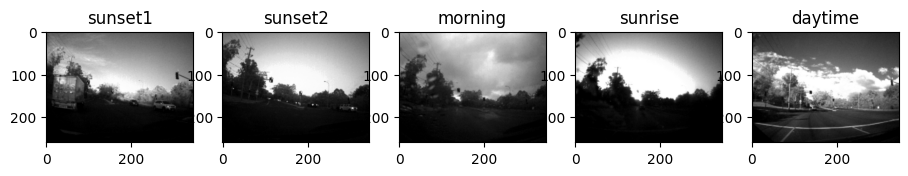

In [22]:
import os
from os.path import join, basename
from os import listdir

def get_timestamp_matches(timestamps, timestamps_to_match):
    timestamps_matched = np.array([np.abs(timestamps - ts).argmin() for ts in timestamps_to_match])
    return timestamps_matched

timestamp_gps = {}
timestamp_frame = {}
timestamp_file_path = {}
matched_timestamp = {}

for traverse in extract_traverses:
    timestamp_gps[traverse] = [t + video_beginning[traverse] for t in coordinates[traverse][:,2]]
    timestamp_frame[traverse] = sorted([float(os.path.splitext(basename(f))[0]) for f in listdir(frame_paths[traverse]) if f.endswith('.png')])
    timestamp_file_path[traverse] = sorted([join(frame_paths[traverse], f) for f in listdir(frame_paths[traverse]) if f.endswith('.png')])
    matched_timestamp[traverse] = get_timestamp_matches(timestamp_frame[traverse], timestamp_gps[traverse])

import pandas as pd
from PIL import Image

def getCorrelationValue(reference: np.array, comparison: np.array) -> float:
    reference = pd.DataFrame(reference.flatten())
    comparison = pd.DataFrame(comparison.flatten())
    result = reference.corrwith(comparison)
    return result[0]

def getTimestampFromFilePath(filepath):
    # Assuming the file path is from the timestampFilePath dictionnary
    return float(filepath.strip('.png\n').split("/")[-1])

# Get the calibrated timestamp for event data, (file name of the frame)
calibrated_timestamps = {}
for traverse in extract_traverses:
    calibrated_timestamps[traverse] = [(getTimestampFromFilePath(timestamp_file_path[traverse][image_index])) for image_index in matched_timestamp[traverse]]


frame_index = 20
plt.figure(figsize=(11,8))
for index, traverse in enumerate(extract_traverses):
    plt.subplot(1, len(extract_traverses), index+1)
    image_index = matched_timestamp[traverse][sampled_points[traverse][frame_index]] 
    frame = np.array(Image.open(timestamp_file_path[traverse][image_index]).convert('L'))

    print(calibrated_timestamps[traverse][frame_index])
    plt.title(f"{traverse}")
    plt.imshow(frame, cmap="gray")

In [28]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

# Function to display frames for a given frame_index
def display_frames(frame_index):
    plt.figure(figsize=(20, 11))
    for index, traverse in enumerate(extract_traverses):
        plt.subplot(1, len(extract_traverses), index + 1)
        image_index = matched_timestamp[traverse][sampled_points[traverse][frame_index]]
        frame = np.array(Image.open(timestamp_file_path[traverse][image_index]).convert('L'))        
        plt.imshow(frame, cmap="gray")
    plt.show()

# Create a slider for frame_index
frame_slider = widgets.IntSlider(
    value=0,  # Initial value
    min=0,  # Minimum value
    max=len(sampled_points[extract_traverses[0]]) - 1,  # Maximum value (based on sampled points)
    step=1,  # Step size
    description='Frame Index:',  # Slider label
    continuous_update=False  # Update only when released
)

# Link the slider to the display function
widgets.interact(display_frames, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame Index:', max=85), Output(…

<function __main__.display_frames(frame_index)>

Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable
Will use fixed size event windows with 40000 events
Output frame rate: variable


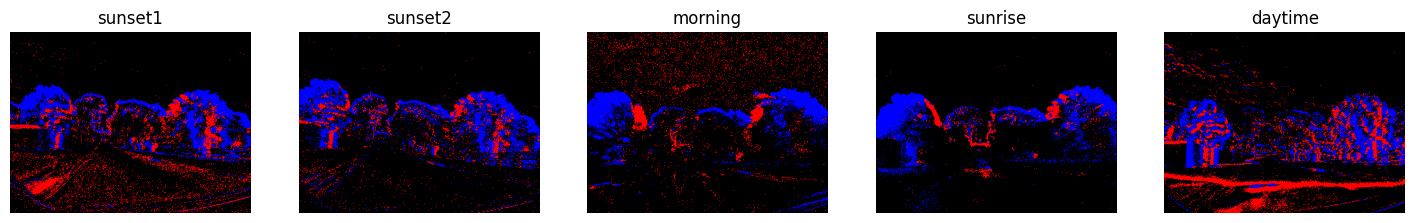

In [38]:
num_events = 40_000
BEGINNING_WINDOW = 0.5
prefix_folder = "./extracted_places/"

plt.figure(figsize=(18,10))
for index, traverse in enumerate(extract_traverses):
    event_reader = FixedSizeEventReader(event_paths[traverse], num_events=num_events)
    plt.subplot(1, len(extract_traverses), index+1)
    for i in range(2):
        image_index = matched_timestamp[traverse][sampled_points[traverse][i]]
        event_pattern = next(event_reader)
        goal_place = calibrated_timestamps[traverse][i]

        current_place = []

        while event_pattern[0][0] < goal_place - BEGINNING_WINDOW:
            try:
                event_pattern = next(event_reader)
            except StopIteration:
                break
        while event_pattern[0][0] < goal_place + BEGINNING_WINDOW:    
            current_place.append(event_pattern)
            try:
                event_pattern = next(event_reader)
            except StopIteration:
                break
        
        plt.imshow(getVisualReprTimeWindow(convertListOfEventsIn2DVector(event_pattern)))
        plt.axis('off')
        plt.title(traverse)
plt.show()

In [41]:
num_events = 40_000
BEGINNING_WINDOW = 0.5
prefix_folder = "./extracted_places/"

extract_traverses = ["morning", "sunrise", "daytime"] # Todo remove after use 

for index, traverse in enumerate(extract_traverses):
    event_reader = FixedSizeEventReader(event_paths[traverse], num_events=num_events)
    for i in range(len(sampled_points[extract_traverses[0]])):
        image_index = matched_timestamp[traverse][sampled_points[traverse][i]]
        event_pattern = next(event_reader)
        goal_place = calibrated_timestamps[traverse][i]

        current_place = []

        while event_pattern[0][0] < goal_place - BEGINNING_WINDOW:
            try:
                event_pattern = next(event_reader)
            except StopIteration:
                break
        while event_pattern[0][0] < goal_place + BEGINNING_WINDOW:    
            current_place.append(event_pattern)
            try:
                event_pattern = next(event_reader)
            except StopIteration:
                break
        current_place = np.array(current_place)
        if len(current_place.shape) > 2:
            n, num, e = current_place.shape
            current_place = current_place.reshape(n*num, e)
        
        else:
            print(f"index {i}, shape : {current_place.shape}")
        # Save the current place of this traverse
        np.save(f"{prefix_folder}{traverse}_{i}_{BEGINNING_WINDOW * 2}.npy", current_place)

Will use fixed size event windows with 40000 events
Output frame rate: variable


ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
a = np.load(f"{prefix_folder}{"sunset1"}_{5}_{BEGINNING_WINDOW * 2}.npy", allow_pickle=True)

a.shape

(280000, 4)